Pontus Hultkrantz

# 2021-08: Robot Tug-of-War
https://www.janestreet.com/puzzles/current-puzzle/

The Robot Weightlifting World Championship was such a huge success that the organizers have hired you to help design its sequel: a Robot Tug-of-War Competition!

In each one-on-one matchup, two robots are tied together with a rope. The center of the rope has a marker that begins above position 0 on the ground. The robots then alternate pulling on the rope. The first robot pulls in the positive direction towards 1; the second robot pulls in the negative direction towards -1. Each pull moves the marker a uniformly random draw from [0,1] towards the pulling robot. If the marker first leaves the interval [‑½,½] past ½, the first robot wins. If instead it first leaves the interval past -½, the second robot wins.

However, the organizers quickly noticed that the robot going second is at a disadvantage. They want to handicap the first robot by changing the initial position of the marker on the rope to be at some negative real number. Your job is to compute the position of the marker that makes each matchup a 50-50 competition between the robots. Find this position to seven significant digits—the integrity of the Robot Tug-of-War Competition hangs in the balance!

## Exploratory simulation

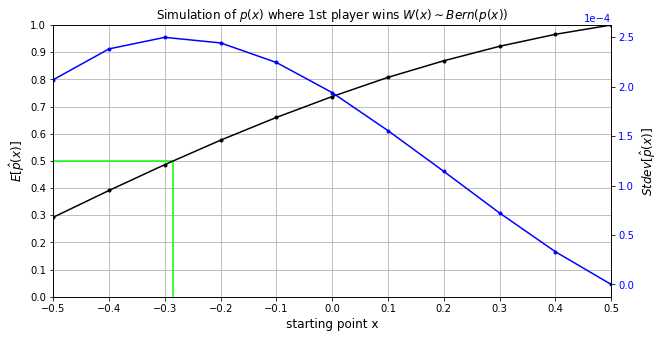

Proxy x* = -0.2847406


In [1]:
import numpy as np
import numba

XBOUND = 0.5 # x in (-XBOUND, XBOUND)
X_NODES = 10+1 # Simulate x at each 0.1 interval.
@numba.njit(parallel=False)
def simulate(x0:float, nsim:int):
    rvs = np.random.random
    wins = 0
    for i in numba.prange(int(nsim)):
        k = -1
        x = x0
        while abs(x) <= XBOUND:
            k *= -1
            x += k*rvs()
        if k > 0:
            wins += 1
    return wins / nsim

nsim = int(1e6)
xx = np.linspace(-XBOUND, XBOUND, X_NODES)
pp = np.array([simulate(x, nsim) for x in xx])

from matplotlib import pyplot as plt
fig, ax = plt.subplots(1,1, figsize=(10, 5))
ax.plot(xx, pp, marker='.', color='k')
ax.set_xlim([-XBOUND, XBOUND]); ax.set_xticks(xx)
ax.set_ylim([0.0, 1.0]); ax.set_yticks(np.linspace(0.0, 1.0, 10+1))
ax.set_title('Simulation of $p(x)$ where 1st player wins $W(x)\sim Bern(p(x))$', fontsize=12)
ax.set_xlabel('starting point x', fontsize=12)
ax.set_ylabel('$E[\hat{p}(x)]$', fontsize=12)
ax.grid()

mc_err = pp*(1-pp) / nsim**0.5
ax2 = ax.twinx()
color = 'b'
ax2.plot(xx, mc_err, marker='.', color=color)
ax2.ticklabel_format(style='sci',scilimits=(0,0),axis='y')
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylabel('$Stdev[\hat{p}(x)]$', fontsize=12)

from scipy.interpolate import interp1d
kind = 'linear'
p_func = interp1d(x=xx, y=pp, kind=kind)
p_func_inv = interp1d(x=pp, y=xx, kind=kind)
x_star = p_func_inv(0.5)
ax.hlines(0.5, -0.5, x_star, color='lime')
ax.vlines(x_star, 0.0, 0.5, color='lime')
plt.show()

print(f'Proxy x* = {x_star:.7f}')

Since $\hat{p}(x) \sim \mathcal{N}\left(p(x), \tfrac{p(x)\cdot (1-p(x))}{N_{MC}}\right)$,
in order to get an estimation error that is less than  $\epsilon = 10^{-7}$ with confidence $\alpha=5\%$ we need a minimum number of Monte Carlo simulations that obeys

$\phi^{-1}[1-\alpha/2] \cdot \frac{1}{2\sqrt{N_{MC}}} \leq \epsilon \implies N_{MC} \geq \left(\tfrac{1}{2\epsilon} \phi^{-1}[1-\alpha/2] \right) \approx 10^{14}$.

Using an Intel® Xeon® W-2145 Processor (8 cores, 16 threads) on Windows 10,
one million simulations takes 3.2 ms multi-threaded (MT) and 37 ms single threaded (ST). Hence, the runtime required to reach necessary tolerance is  3.7 days (MT) and 43 days (ST).

Remember that this assumes that we want to estimate p given x. In our case, we know p and need to find x, hence we need to invert the function. Since $\tfrac{d}{dx}p(x) \approx 1$ around $x^*$ the magnitude of the error is approximately the same for estimating $x^*= p^{-1}(0.5)$. However, we would need to run several simulations in sequence, each with an updated starting point $x$. Hence the runtime will be multiples of our original estimate, and therefore not feasible to perform in practise.


## Analytical

Let $W(x)=W(x; U_1, U_2, ...) \sim Bern(p(x))$ denote the stochatic result of a game for the first player when the game starts at position x. Then the following holds

\begin{align}
W(x) &=  \mathbb{1}\left\{U_1>\tfrac{1}{2}-x\right\} + \mathbb{1}\left\{U_1\leq \tfrac{1}{2}-x\right\} \mathbb{1}\left\{U_2\leq x+U_1 + \tfrac{1}{2}\right\}\cdot W(x+U_1-U_2) \\
&= \mathbb{1}\left\{U_1>\tfrac{1}{2}-x\right\} + \mathbb{1}\left\{U_1,U_2 \in \mathcal{R}(x)\right\}\cdot W(x+U_1-U_2),
\end{align}
where $\mathcal{R}(x)$ is the region corresponding to the event that the game does not finish by the second turn. In order for the first player to win, he must either win on the first turn $\left(U_1>\tfrac{1}{2}-x\right)$, or else player two must not win on the second turn $\left(U_2 \leq x + U_1 + \tfrac{1}{2}\right)$, so that player one can have a new chance on turn 3; now starting at a new position $W(x+U_1-U_2)$. Furthermore, we note that $\mathbb{P}\left[W(\tfrac{1}{2})=1\right]=1$, i.e. player one surely wins if the starting position is $\tfrac{1}{2}$, hence $\mathbb{E}\left[W(\tfrac{1}{2})\right]=1$.




Taking expectations on both sides, and denoting $p(x) = \mathbb{E}[W(x)]$

\begin{align}
p(x) &= \mathbb{P}(U_1>\tfrac{1}{2}-x) + \mathbb{E}\left[\mathbb{1}(U_1,U_2 \in \mathcal{R}(x))\cdot W(x+U_1-U_2) \right] \\
&= \tfrac{1}{2} + x + \int_0^1 \int_0^1\mathbb{E}\left[\mathbb{1}(u_1,u_2 \in \mathcal{R}(x))\cdot W(x+u_1-u_2) \big| U_1=u_1, U_2=u_2 \right] du_1 du_2 \\
&= \tfrac{1}{2} + x + \int_0^1 \int_0^1\mathbb{1}\{u_1,u_2 \in \mathcal{R}(x)\}\cdot \mathbb{E}\left[W(x+u_1-u_2; U_3, ...) \right] du_1 du_2 \\
&= \tfrac{1}{2} + x +  \int_0^{1/2-x} \int_0^{1/2 + x+u_1}p(x+u_1-u_2) du_2 du_1 \\
&= \tfrac{1}{2} + x  - M(-\tfrac{1}{2})(\tfrac{1}{2}-x) + \int_x^{1/2} M(s) ds \\
&= \tfrac{1}{2} + x + \int_x^{1/2} M(s) ds,
\end{align}
where $M(x):=\int_{-1/2}^x p(s)ds$ is the primitive function of $p(x)$.


Now differentiating both sides once and twice yield
\begin{align}
p'(x) &= 1  - M(x), \\
p''(x) &= -p(x).
\end{align}
Together with the boundary condition $p(\tfrac{1}{2})=1$ and ansatz $p(x) = c_1 \sin(x) + c_2 \cos(x)$, the system of ODEs has the solution

\begin{align}
p(x) &= \frac{\sin(x) + \cos(x)}{\sin(1/2) + \cos(1/2)} = \frac{\sin\left(x+\pi/4\right)}{\sin(1/2+\pi/4)},
\end{align}

where we in the last step used the identity $\sin(\alpha+\beta)=\sin(\alpha)\cos(\beta) + \cos(\alpha)\sin(\beta)$.

The corresponding inverted function is
\begin{align}
x(p) = \arcsin(p \cdot \sin(1/2+\pi/4)) - \pi/4,
\end{align}

and our asnwer is given by $x(0.5) \approx -0.2850001$.
